# Variational Autoencoder for Collaborative Filtering*

## 1.Model

<br>u $\epsilon$ {1,...,U}
<br>i $\epsilon$ {1,...,I}
<br> User-item interaction matrix: $X \, \epsilon \, \mathbb{N}^{U \times I}$ where $x_u=[x_{u1},...,x_{uI}]^T \, \epsilon \, \mathbb{N}^I$

<br>$z_u$: K-dimensional hidden factor for user u
<br>$f_{\theta}(.)$: non-linear function $\epsilon \, \mathbb{R}^I$
<br>$\pi(z_u)$: the probability function from which $x_u$ vector is assumed to be drawn
<br>$N_u=\sum_{i} x_{ui}$: Total number of clicks given the user u

$$z_u \sim N(0,I_k)$$
$$\pi(z_u) \propto exp(\, f_{\theta}(z_u)\,)$$
$$x_u \sim Mult(N_u, \pi(z_u))$$

Log-likelihood function: $log\, p_{\theta}(x_u | z_u)=\sum_i x_{ui} \, log \, \pi_i(z_u)$
For comparison:
1. Gaussian Log-likelihood
2. Logistic log-likelihood

## 2. Variational Inference

To learn the generative model we need to estimate the parameter $\theta$ of the non-linear function $f_{\theta}(.)$. To do so, the intractable posterior $p(z_u |x_u)$ needs to be calculated for each data point. Variational inference approximates the true posterior to an instrumental posterior $q(z_u)$ with Kullback-Leibler divergence $KL(q(z_u) || p(z_u |x_u))$ where,
$$q(z_u) \sim \mathcal{N}(\mu_u,diag\{\sigma^2_u\})$$

We select diagonal covariance, because we want the latent variables $z_i$'s to be independent, thus interpretable. The objective of variational inference to select $(\mu_u, \sigma^2_u)$ so that $KL(q(z_u) || p(z_u |x_u))$ is minimized.

### 2.1.Amortized inference and variational autoencoders

The number of variational parameters $(\mu_u, \sigma^2_u)$ grows with the number of users and items in the dataset. This is a bottleneck for commercial recommendation systems, since there are millions of users and items. To cope with this issue, variational autoencoders are used which are in fact data-dependent function. This is commonly called the inference model:
$$g_{\phi}(x_u)=[\mu_{\phi}(x_u), \sigma_{\phi}(x_u)] \: \epsilon \: \mathbb{R}^{2K}$$
Thus the variational distribution becomes also data-dependent:
$$q_{\phi}(z_u |x_u) \sim \mathcal{N}(\mu_{\phi}(x_u), diag\{\sigma^2_{\phi}(x_u)\})$$

Variational autoencoders ease the new inference problems analyzing user preferences by exploiting the similarity patterns inferred from past experiences.

*Learning VAEs:

\begin{align*}
KL(q_{\phi}(z_u |x_u) || p_{\theta}(z_u |x_u)) &= \mathbb{E}_q [log\,q_{\phi}(z_u |x_u)-log \, p_{\theta}(z_u |x_u) ] \qquad  \textbf{Eq.(1)} \\
&=\mathbb{E}_q [log\,q_{\phi}(z_u |x_u)-log \, p_{\theta}(z_u ,x_u)+ log\, p_{\theta}(x_u)] \\
&=\mathbb{E}_q [log\,q_{\phi}(z_u |x_u)-log \, p_{\theta}(x_u|z_u) -log\, p(z_u)] +log \, p_{\theta}(x_u)
\end{align*}

The evidence $p(x_u)$ is a constant term, and KL divergence is a non negative term, we can rearrange the equation as below:

$$log\, p_{\theta}(x_u)\geq \mathbb{E}_q[log\, p_{\theta}(x_u|z_u)]-KL(q_{\phi}(z_u|x_u)||p(z_u)) \equiv \mathcal{L}(x_u;\theta, \phi) \qquad \textbf{Eq.(2)}$$

$\mathcal{L}(x_u;\theta, \phi)$ is called evidence lower bound(ELBO).


Minimizing KL term in Eq.(1) is the same thing as maximizing ELBO.

*Reparameterization trick:

We can estimate the ELBO by sampling $z_u \sim q_{\phi}$ and make gradient ascent to optimize it. However, we can not take gradient of $q_{\phi}$ w.r.t. $\phi$. So we do the reparameterization trick:

1. Sample $\epsilon \sim \mathcal{N}(0,I_k)$
2. Reparameterize $z_u$ such that $z_u=[\mu_{\phi}(x_u),\epsilon \odot \sigma_{\phi}(x_u)]$

####  Algorithm I: VAE-SGD

<br>$\textbf{Input}$:Click matrix $X \, \epsilon \, \mathbb{N}^{I \times U}$
<br>Initialize $\phi$ and $\theta$
<br>$\textbf{While}$ $\textit{not converged}$ $\textbf{do}$
<br>$\:\:$sample a batch of users $\mathcal{U}$
<br>$\:\:$$\textbf{for}$ all $u \, \epsilon \, \mathcal{U}$ $\textbf{do}$
<br>$\:\:\:$sample $\epsilon \, \sim \, \mathcal{N}(0, I_k)$ and calculate $z_u$
<br>$\:\:\:$compute noisy gradient $\nabla_{\phi} \mathcal{L}$ and $\nabla_{\theta} \mathcal{L}$
<br>$\:\:$$\textbf{end}$
<br>$\:\:$Average the noisy gradients over batch
<br>$\:\:$Update $\phi$ and $\theta$ using gradient steps
<br>$\textbf{end}$

### 2.2.Alternative Interpretation of ELBO

We now define a new ELBO which interpretes first term in Eq.(2) as (negative) reconstruction error and the second term, KL term, as the regularization term.

$$\mathcal{L}_{\beta}(x_u;\theta, \phi)=\mathbb{E}_{q_{\phi}(z_u|x_u)}[log\, p_{\theta}(x_u|z_u)]-\beta \, \dot \,KL(q_{\phi}(z_u|x_u)||p(z_u)) $$

This regularization view of ELBO trades off between how well we can fit the data and how close the approximate posterior stays to the prior.

Selecting $\textbf{$\beta$}$: Using KL-annealing


#### Derivation of $KL(q_{\phi}(z_u|x_u)||p(z_u))$

\begin{align*}
KL(q_{\phi}(z_u |x_u) || p(z_u )) &= \mathbb{E}_q [log\,q_{\phi}(z_u |x_u)-log \, p(z_u ) ]  \\
&=\mathbb{E}_q [log\,\mathcal{N}(z;\mu_{\phi}(x),\Sigma_{\phi}(x))]-\mathbb{E}_q[log \, \mathcal{N}(z;0,I_k)] \:\: \textbf{Eq.(3)}\\
\end{align*}

First term in Eq.(3):
\begin{align*}
\mathbb{E}_q [log\,\mathcal{N}(z;\mu_{\phi}(x),\Sigma_{\phi}(x))]&=
\mathbb{E}_q[-\frac{1}{2}log\, (2\pi)^k]+
\mathbb{E}_q[-\frac{1}{2}log\,|\Sigma_{\phi}(x)|]
-\frac{1}{2}\mathbb{E}_q[z^T \Sigma_{\phi}(x)^{-1}z-z^T \Sigma_{\phi}(x)^{-1}\mu_{\phi}(x)-\mu_{\phi}(x)^T \Sigma_{\phi}(x)^{-1} z+ \mu_{\phi}(x)^T \Sigma_{\phi}(x)^{-1} \mu_{\phi}(x)] \\
&=-\frac{k}{2}\, log(2\pi)-\frac{1}{2} log |\Sigma(x)|
-\frac{1}{2}\mathbb{E}_q[(tr(z z^T \Sigma^{-1}-\mu z^T\Sigma^{-1}-z \mu^T\Sigma^{-1}+\mu \mu^T\Sigma^{-1}))] \\
&=D-\frac{1}{2} log |\Sigma(x)|
-\frac{1}{2}\mathbb{E}_q[ tr(\Sigma \Sigma^{-1})] \\
&=D-\frac{1}{2} log |\Sigma(x)|-\frac{1}{2}k
\end{align*}

k is the dimension of z and $D=-\frac{k}{2}\, log(2\pi)$. For the simplicity in the derivation $\mu_{\phi}(x)$ and $\Sigma_{\phi}(x)$ are replaced by $\mu$ and $\Sigma$, respectively.

Second term in Eq.(3):

\begin{align*}
\mathbb{E}_q[log \, \mathcal{N}(z;0,I_k)]&= D+\mathbb{E}_q[-\frac{1}{2} z^T I_k^{-1}z] \\
&=-\frac{1}{2}\mathbb{E}_q[(z^Tz -2 z^T \mu + \mu^T \mu +2 z^T \mu - \mu^T \mu)] \\
&=-\frac{1}{2}\mathbb{E}_q[tr(z z^T -2 z \mu^T + \mu \mu^T +2 z \mu^T - \mu \mu^T)] \\
&=-\frac{1}{2}\mathbb{E}_q[tr(z z^T -2 z \mu^T + \mu \mu^T )]-\frac{1}{2}\mathbb{E}_q[tr(2 z \mu^T - \mu \mu^T )] \\
&=-\frac{1}{2}tr(\mathbb{E}_q[(z-\mu)(z-\mu)^T])-\frac{1}{2}2tr(\mathbb{E}_q[ z ]\mu^T) +\frac{1}{2}tr(\mu \mu^T ) \\
&=-\frac{1}{2}tr(\Sigma) -\frac{1}{2}\mu^T \mu
\end{align*}

Combining the first and second term we have:

\begin{align*}
KL&=-\frac{1}{2} log |\Sigma|-\frac{1}{2}k +\frac{1}{2}tr(\Sigma) +\frac{1}{2}\mu^T \mu \\
&=\sum_k \frac{1}{2}(-log \, \sigma_k^2 -1 + \sigma^2_k +\mu_K^2)
\end{align*}

## Implementation in Keras

Encoder network $q(z_u|x_u)$

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), (np.prod(x_test.shape[1:]))))

original_dim = x_train.shape[1]
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 100
latent_dim = 2
epochs = 10

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

(10000, 784)


In [3]:
x_train.shape

(60000, 784)

####  Sampling of z
$z=\mu (X) + \Sigma^{\frac{1}{2}}(X) \, \epsilon$

In [4]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#### Decoder network 
$p(x_u|z_u)$

In [5]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

#### Reconstruction of inputs

In [6]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

#### VAE-loss

In [7]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [8]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 140us/step - loss: 0.2932 - val_loss: 0.2629
Epoch 2/50
60000/60000 [==============================] - 9s 152us/step - loss: 0.2631 - val_loss: 0.2628
Epoch 3/50
60000/60000 [==============================] - 8s 138us/step - loss: 0.2631 - val_loss: 0.2628
Epoch 4/50
60000/60000 [==============================] - 8s 133us/step - loss: 0.2630 - val_loss: 0.2629
Epoch 5/50
60000/60000 [==============================] - 8s 133us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 6/50
60000/60000 [==============================] - 8s 131us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 7/50
60000/60000 [==============================] - 9s 146us/step - loss: 0.2630 - val_loss: 0.2628
Epoch 8/50
60000/60000 [==============================] - 8s 133us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 9/50
60000/60000 [==============================] - 11s 179us/step - loss: 0.2630 - val_loss: 0.

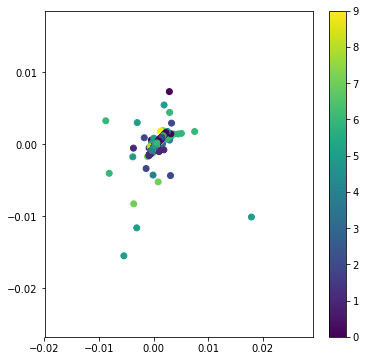

In [9]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.tight_layout()
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

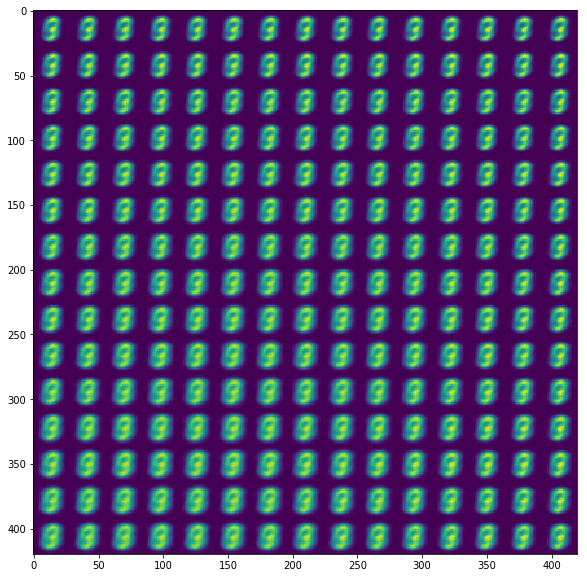

In [11]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1.0
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()